1: Test Coolprop Enthalpy vs SWEOS

685311.1020528341
686709.5982218048
688127.9508296051
688972.4505201334
689601.9339954094
690225.2927549697
690842.6286970172
691454.0413230101
692059.6278103554
692659.4830824105
693253.6998759102
693842.3688059247
694425.5784284668
695003.4153008317
695575.9640397873
696143.3073776854
696705.5262165938
697262.6996805293
697814.905165864

average enthalpy offset: 692420.6091673233



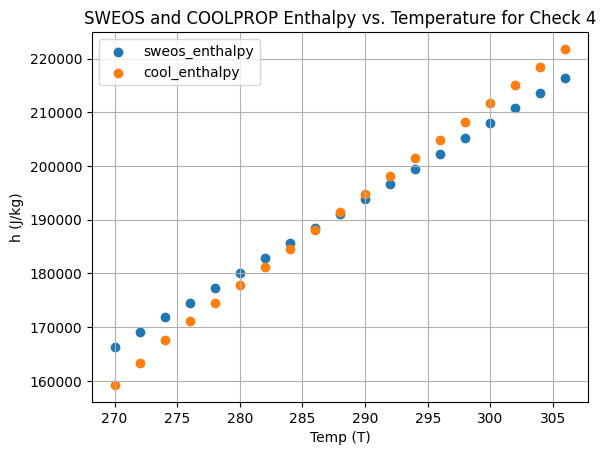

In [36]:
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

def thermo_span_wagner(rho, T, param):
    nist_conversion = 0 # 7.3397e+5 #NOTE: Convert SW int Energy to NIST convention

    # Constants for N2O
    R = 8.3144598 / 44.0128 * 1000 # Gas constant (kJ/kg*K)
    T_c = 309.52  # Critical Temperature (K)
    rho_c = 452.0115  # Critical Density (kg/m^3)

    n0 = np.array([0.88045, -2.4235, 0.38237, 0.068917, 0.00020367, 0.13122, 0.46032,
          -0.0036985, -0.23263, -0.00042859, -0.042810, -0.023038])
    n1 = n0[0:5]
    n2 = n0[5:12]
    a1 = 10.7927224829
    a2 = -8.2418318753
    c0 = 3.5
    v0 = np.array([2.1769, 1.6145, 0.48393])
    u0 = np.array([879, 2372, 5447])
    t0 = np.array([0.25, 1.125, 1.5, 0.25, 0.875, 2.375, 2, 2.125, 3.5, 6.5, 4.75, 12.5])
    d0 = np.array([1, 1, 1, 3, 7, 1, 2, 5, 1, 1, 4, 2])
    P0 = np.array([1, 1, 1, 2, 2, 2, 3])
    t1 = t0[0:5]
    t2 = t0[5:12]
    d1 = d0[0:5]
    d2 = d0[5:12]

    # Calculate non-dimensional variables
    tau = T_c / T
    delta = rho / rho_c

    # Calculate explicit Helmholtz energy and derivatives
    ao = a1 + a2 * tau + np.log(delta) + (c0 - 1) * np.log(tau) + np.sum(v0 * np.log(1 - np.exp(-u0 * tau / T_c)))
    ar = np.sum(n1 * tau**t1 * delta**d1) + np.sum(n2 * tau**t2 * delta**d2 * np.exp(-delta**P0))
    ao_tau = a2 + (c0 - 1) / tau + np.sum(v0 * u0 / T_c * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c)))
    ao_tautau = -(c0 - 1) / tau**2 + np.sum(-v0 * u0**2 / T_c**2 * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c))**2)
    ar_tau = np.sum(n1 * t1 * tau**(t1 - 1) * delta**d1) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**d2 * np.exp(-delta**P0))
    ar_tautau = np.sum(n1 * t1 * (t1 - 1) * tau**(t1 - 2) * delta**d1) + np.sum(n2 * t2 * (t2 - 2) * tau**(t2 - 2) * delta**d2 * np.exp(-delta**P0))
    ar_delta = np.sum(n1 * d1 * delta**(d1 - 1) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))
    ar_deltadelta = np.sum(n1 * d1 * (d1 - 1) * delta**(d1 - 2) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 2) * ((d2 - P0 * delta**P0) * (d2 - 1 - P0 * delta**P0) - P0**2 * delta**P0) * np.exp(-delta**P0))
    ar_deltatau = np.sum(n1 * d1 * t1 * delta**(d1 - 1) * tau**(t1 - 1)) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))

    out = 0.0
    if param == 'p':  # Pressure (Pa)
        out = rho * R * T * (1 + delta * ar_delta)
    elif param == 'u':  # Specific internal energy (J/kg)
        out = R * T * tau * (ao_tau + ar_tau) + nist_conversion
    elif param == 's':  # Specific entropy (J/kg*K)
        out = R * (tau * (ao_tau + ar_tau) - ao - ar) + nist_conversion
    elif param == 'h':  # Specific enthalpy (J/kg)
        out = R * T * (1 + tau * (ao_tau + ar_tau) + delta * ar_delta) + nist_conversion
    elif param == 'cv':  # Specific heat constant volume (J/kg*K)
        out = R * -tau**2 * (ao_tautau + ar_tautau)
    elif param == 'cp':  # Specific heat constant pressure (J/kg*K)
        out = R * (-tau**2 * (ao_tautau + ar_tautau) + (1 + delta * ar_delta - delta * tau * ar_deltatau)**2 / (1 + 2 * delta * ar_delta + delta**2 * ar_deltadelta))
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'du_drho_const_T': # 
        out = R * T * ( tau * delta * ar_deltatau)
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'dP_dT_const_rho':
        out = rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )
    elif param == 'dP_drho_const_T':
        out = R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta )
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'd_rho_dT_const_P':
        out = (rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )) / (R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta ))
    else:
        raise NotImplementedError(f'{param} is not implemented or incorrectly entered, see thermo_span_wagner()')

    return out


# NEED ISOCHORIC PROPERTIES
RHO = 900
temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
sweos_enthalpy =[]
cool_enthalpy = []

offsets = []

for T in temp_arr:
    sweos_enthalpy.append( thermo_span_wagner(RHO, T, 'h') + 692420.6091673233 ) 
    cool_enthalpy.append( CP.PropsSI('H', 'T', T, 'D', RHO, 'N2O') )

    print(CP.PropsSI('H', 'T', T, 'D', RHO, 'N2O') - thermo_span_wagner(RHO, T, 'h')  )

    offsets.append( CP.PropsSI('H', 'T', T, 'D', RHO, 'N2O') - thermo_span_wagner(RHO, T, 'h') )


average = sum(offsets) / len(offsets)
print(f"\naverage enthalpy offset: {average}\n")


plt.scatter(temp_arr, sweos_enthalpy, label = "sweos_enthalpy")
plt.scatter(temp_arr, cool_enthalpy, label = "cool_enthalpy")
plt.xlabel('Temp (T)')
plt.ylabel('h (J/kg)')
plt.title('SWEOS and COOLPROP Enthalpy vs. Temperature for Check 4')
plt.legend()
plt.grid(True)
plt.show()






2: Check Entropy

2719.75809005829
2728.9969580153843
2738.2367681536216
2741.6515267361856
2742.9658275795055
2744.258096372887
2745.528854430536
2746.778607172281
2748.0078447153733
2749.2170424403016
2750.406661531963
2751.5771494973924
2752.728940661231
2753.862456640041
2754.9781067964905
2756.076288674406
2757.157388415605
2758.2217811594023
2759.2698314255967

average enthalpy offset: 2747.351485288236



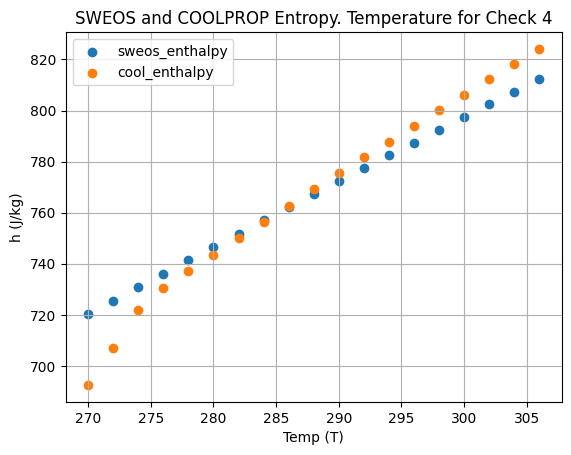

In [37]:
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

def thermo_span_wagner(rho, T, param):
    nist_conversion = 0 # 7.3397e+5 #NOTE: Convert SW int Energy to NIST convention

    # Constants for N2O
    R = 8.3144598 / 44.0128 * 1000 # Gas constant (kJ/kg*K)
    T_c = 309.52  # Critical Temperature (K)
    rho_c = 452.0115  # Critical Density (kg/m^3)

    n0 = np.array([0.88045, -2.4235, 0.38237, 0.068917, 0.00020367, 0.13122, 0.46032,
          -0.0036985, -0.23263, -0.00042859, -0.042810, -0.023038])
    n1 = n0[0:5]
    n2 = n0[5:12]
    a1 = 10.7927224829
    a2 = -8.2418318753
    c0 = 3.5
    v0 = np.array([2.1769, 1.6145, 0.48393])
    u0 = np.array([879, 2372, 5447])
    t0 = np.array([0.25, 1.125, 1.5, 0.25, 0.875, 2.375, 2, 2.125, 3.5, 6.5, 4.75, 12.5])
    d0 = np.array([1, 1, 1, 3, 7, 1, 2, 5, 1, 1, 4, 2])
    P0 = np.array([1, 1, 1, 2, 2, 2, 3])
    t1 = t0[0:5]
    t2 = t0[5:12]
    d1 = d0[0:5]
    d2 = d0[5:12]

    # Calculate non-dimensional variables
    tau = T_c / T
    delta = rho / rho_c

    # Calculate explicit Helmholtz energy and derivatives
    ao = a1 + a2 * tau + np.log(delta) + (c0 - 1) * np.log(tau) + np.sum(v0 * np.log(1 - np.exp(-u0 * tau / T_c)))
    ar = np.sum(n1 * tau**t1 * delta**d1) + np.sum(n2 * tau**t2 * delta**d2 * np.exp(-delta**P0))
    ao_tau = a2 + (c0 - 1) / tau + np.sum(v0 * u0 / T_c * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c)))
    ao_tautau = -(c0 - 1) / tau**2 + np.sum(-v0 * u0**2 / T_c**2 * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c))**2)
    ar_tau = np.sum(n1 * t1 * tau**(t1 - 1) * delta**d1) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**d2 * np.exp(-delta**P0))
    ar_tautau = np.sum(n1 * t1 * (t1 - 1) * tau**(t1 - 2) * delta**d1) + np.sum(n2 * t2 * (t2 - 2) * tau**(t2 - 2) * delta**d2 * np.exp(-delta**P0))
    ar_delta = np.sum(n1 * d1 * delta**(d1 - 1) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))
    ar_deltadelta = np.sum(n1 * d1 * (d1 - 1) * delta**(d1 - 2) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 2) * ((d2 - P0 * delta**P0) * (d2 - 1 - P0 * delta**P0) - P0**2 * delta**P0) * np.exp(-delta**P0))
    ar_deltatau = np.sum(n1 * d1 * t1 * delta**(d1 - 1) * tau**(t1 - 1)) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))

    out = 0.0
    if param == 'p':  # Pressure (Pa)
        out = rho * R * T * (1 + delta * ar_delta)
    elif param == 'u':  # Specific internal energy (J/kg)
        out = R * T * tau * (ao_tau + ar_tau) + nist_conversion
    elif param == 's':  # Specific entropy (J/kg*K)
        out = R * (tau * (ao_tau + ar_tau) - ao - ar) + nist_conversion
    elif param == 'h':  # Specific enthalpy (J/kg)
        out = R * T * (1 + tau * (ao_tau + ar_tau) + delta * ar_delta) + nist_conversion
    elif param == 'cv':  # Specific heat constant volume (J/kg*K)
        out = R * -tau**2 * (ao_tautau + ar_tautau)
    elif param == 'cp':  # Specific heat constant pressure (J/kg*K)
        out = R * (-tau**2 * (ao_tautau + ar_tautau) + (1 + delta * ar_delta - delta * tau * ar_deltatau)**2 / (1 + 2 * delta * ar_delta + delta**2 * ar_deltadelta))
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'du_drho_const_T': # 
        out = R * T * ( tau * delta * ar_deltatau)
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'dP_dT_const_rho':
        out = rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )
    elif param == 'dP_drho_const_T':
        out = R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta )
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'd_rho_dT_const_P':
        out = (rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )) / (R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta ))
    else:
        raise NotImplementedError(f'{param} is not implemented or incorrectly entered, see thermo_span_wagner()')

    return out



# NEED ISOCHORIC PROPERTIES
RHO = 900
temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
sweos_entropy =[]
cool_entropy = []

offsets = []

for T in temp_arr:
    sweos_entropy.append( thermo_span_wagner(RHO, T, 's') + 2747.351485288236)
    cool_entropy.append( CP.PropsSI('S', 'T', T, 'D', RHO, 'N2O') )

    print(CP.PropsSI('S', 'T', T, 'D', RHO, 'N2O') - thermo_span_wagner(RHO, T, 's')  )

    offsets.append( CP.PropsSI('S', 'T', T, 'D', RHO, 'N2O') - thermo_span_wagner(RHO, T, 's') )


average = sum(offsets) / len(offsets)
print(f"\naverage enthalpy offset: {average}\n")


plt.scatter(temp_arr, sweos_entropy, label = "sweos_enthalpy")
plt.scatter(temp_arr, cool_entropy, label = "cool_enthalpy")
plt.xlabel('Temp (T)')
plt.ylabel('h (J/kg)')
plt.title('SWEOS and COOLPROP Entropy. Temperature for Check 4')
plt.legend()
plt.grid(True)
plt.show()


3. Check internal energy

659851.9123311039
661773.3949958081
663794.1768920628
665909.3079533902
668114.6302868405
670406.7602079661
672783.0910019778
675241.8210692971
677782.0150596221
680403.7103866601
683108.0896537168
685897.7540281934
688777.1598912207
691753.3357424194
694837.1144658631
698045.3969994914
701405.7206701946
704966.8328514763
708170.4443372912

average enthalpy offset: 681738.0352012947



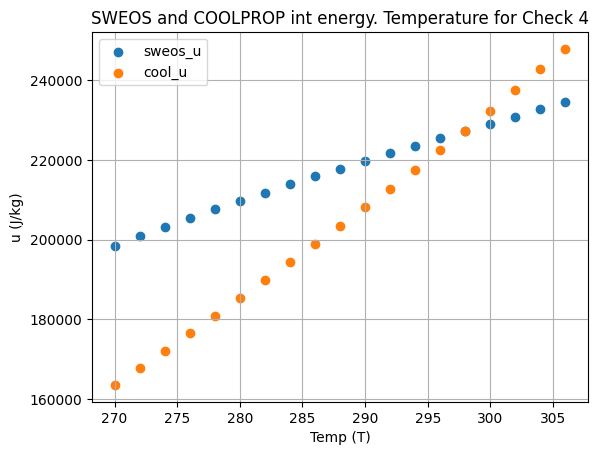

In [42]:
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

def thermo_span_wagner(rho, T, param):
    nist_conversion = 0 # 7.3397e+5 #NOTE: Convert SW int Energy to NIST convention

    # Constants for N2O
    R = 8.3144598 / 44.0128 * 1000 # Gas constant (kJ/kg*K)
    T_c = 309.52  # Critical Temperature (K)
    rho_c = 452.0115  # Critical Density (kg/m^3)

    n0 = np.array([0.88045, -2.4235, 0.38237, 0.068917, 0.00020367, 0.13122, 0.46032,
          -0.0036985, -0.23263, -0.00042859, -0.042810, -0.023038])
    n1 = n0[0:5]
    n2 = n0[5:12]
    a1 = 10.7927224829
    a2 = -8.2418318753
    c0 = 3.5
    v0 = np.array([2.1769, 1.6145, 0.48393])
    u0 = np.array([879, 2372, 5447])
    t0 = np.array([0.25, 1.125, 1.5, 0.25, 0.875, 2.375, 2, 2.125, 3.5, 6.5, 4.75, 12.5])
    d0 = np.array([1, 1, 1, 3, 7, 1, 2, 5, 1, 1, 4, 2])
    P0 = np.array([1, 1, 1, 2, 2, 2, 3])
    t1 = t0[0:5]
    t2 = t0[5:12]
    d1 = d0[0:5]
    d2 = d0[5:12]

    # Calculate non-dimensional variables
    tau = T_c / T
    delta = rho / rho_c

    # Calculate explicit Helmholtz energy and derivatives
    ao = a1 + a2 * tau + np.log(delta) + (c0 - 1) * np.log(tau) + np.sum(v0 * np.log(1 - np.exp(-u0 * tau / T_c)))
    ar = np.sum(n1 * tau**t1 * delta**d1) + np.sum(n2 * tau**t2 * delta**d2 * np.exp(-delta**P0))
    ao_tau = a2 + (c0 - 1) / tau + np.sum(v0 * u0 / T_c * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c)))
    ao_tautau = -(c0 - 1) / tau**2 + np.sum(-v0 * u0**2 / T_c**2 * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c))**2)
    ar_tau = np.sum(n1 * t1 * tau**(t1 - 1) * delta**d1) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**d2 * np.exp(-delta**P0))
    ar_tautau = np.sum(n1 * t1 * (t1 - 1) * tau**(t1 - 2) * delta**d1) + np.sum(n2 * t2 * (t2 - 2) * tau**(t2 - 2) * delta**d2 * np.exp(-delta**P0))
    ar_delta = np.sum(n1 * d1 * delta**(d1 - 1) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))
    ar_deltadelta = np.sum(n1 * d1 * (d1 - 1) * delta**(d1 - 2) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 2) * ((d2 - P0 * delta**P0) * (d2 - 1 - P0 * delta**P0) - P0**2 * delta**P0) * np.exp(-delta**P0))
    ar_deltatau = np.sum(n1 * d1 * t1 * delta**(d1 - 1) * tau**(t1 - 1)) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))

    out = 0.0
    if param == 'p':  # Pressure (Pa)
        out = rho * R * T * (1 + delta * ar_delta)
    elif param == 'u':  # Specific internal energy (J/kg)
        out = R * T * tau * (ao_tau + ar_tau) + nist_conversion
    elif param == 's':  # Specific entropy (J/kg*K)
        out = R * (tau * (ao_tau + ar_tau) - ao - ar) + nist_conversion
    elif param == 'h':  # Specific enthalpy (J/kg)
        out = R * T * (1 + tau * (ao_tau + ar_tau) + delta * ar_delta) + nist_conversion
    elif param == 'cv':  # Specific heat constant volume (J/kg*K)
        out = R * -tau**2 * (ao_tautau + ar_tautau)
    elif param == 'cp':  # Specific heat constant pressure (J/kg*K)
        out = R * (-tau**2 * (ao_tautau + ar_tautau) + (1 + delta * ar_delta - delta * tau * ar_deltatau)**2 / (1 + 2 * delta * ar_delta + delta**2 * ar_deltadelta))
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'du_drho_const_T': # 
        out = R * T * ( tau * delta * ar_deltatau)
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'dP_dT_const_rho':
        out = rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )
    elif param == 'dP_drho_const_T':
        out = R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta )
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'd_rho_dT_const_P':
        out = (rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )) / (R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta ))
    else:
        raise NotImplementedError(f'{param} is not implemented or incorrectly entered, see thermo_span_wagner()')

    return out



# NEED ISOCHORIC PROPERTIES
RHO = 650
temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
sweos_u =[]
cool_u = []

offsets = []

for T in temp_arr:
    sweos_u.append( thermo_span_wagner(RHO, T, 'u') +  694758.4344871361 )
    cool_u.append( CP.PropsSI('U', 'T', T, 'D', RHO, 'N2O') )

    print(CP.PropsSI('U', 'T', T, 'D', RHO, 'N2O') - thermo_span_wagner(RHO, T, 'u')  )

    offsets.append( CP.PropsSI('U', 'T', T, 'D', RHO, 'N2O') - thermo_span_wagner(RHO, T, 'u') )


average = sum(offsets) / len(offsets)
print(f"\naverage enthalpy offset: {average}\n")


plt.scatter(temp_arr, sweos_u, label = "sweos_u")
plt.scatter(temp_arr, cool_u, label = "cool_u")
plt.xlabel('Temp (T)')
plt.ylabel('u (J/kg)')
plt.title('SWEOS and COOLPROP int energy. Temperature for Check 4')
plt.legend()
plt.grid(True)
plt.show()

Now that we have the correct reference shift, we can use coolprop + central difference to estimate the partials and compare our sweos implementation

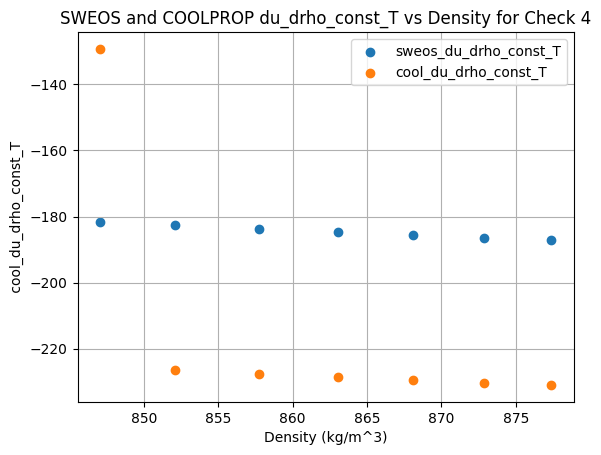

In [39]:
import numpy as np
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt

def coolprop_sat_adjust_ref_state(rho,T, param):

    out = 0.0
    if param == 'u':  # Specific internal energy (J/kg)
        out = CP.PropsSI('U', 'D', rho, 'T', T, 'N2O') - 694758.4344871361
    elif param == 's':  # Specific entropy (J/kg*K)
        out = CP.PropsSI('S', 'D', rho, 'T', T, 'N2O')  - 2747.351485288236
    elif param == 'h':  # Specific enthalpy (J/kg)
        out = CP.PropsSI('H', 'D', rho, 'T', T, 'N2O')  - 692420.6091673233

    else:
        raise NotImplementedError(f'{param} is not implemented or incorrectly entered, see thermo_span_wagner()')

    return out

def solve_du_drho_const_T_liq_central_differences(rho, delta_rho, T):
    rho_0 = rho - delta_rho
    u_dep_0 = coolprop_sat_adjust_ref_state(rho_0, T, 'u')

    rho_1 = rho + delta_rho
    u_dep_1 = coolprop_sat_adjust_ref_state(rho_1, T, 'u')

    return (u_dep_1-u_dep_0)/(rho_1-rho_0)

def thermo_span_wagner(rho, T, param):

    # Constants for N2O
    R = 8.3144598 / 44.0128 * 1000 # Gas constant (kJ/kg*K)
    T_c = 309.52  # Critical Temperature (K)
    rho_c = 452.0115  # Critical Density (kg/m^3)

    n0 = np.array([0.88045, -2.4235, 0.38237, 0.068917, 0.00020367, 0.13122, 0.46032,
          -0.0036985, -0.23263, -0.00042859, -0.042810, -0.023038])
    n1 = n0[0:5]
    n2 = n0[5:12]
    a1 = 10.7927224829
    a2 = -8.2418318753
    c0 = 3.5
    v0 = np.array([2.1769, 1.6145, 0.48393])
    u0 = np.array([879, 2372, 5447])
    t0 = np.array([0.25, 1.125, 1.5, 0.25, 0.875, 2.375, 2, 2.125, 3.5, 6.5, 4.75, 12.5])
    d0 = np.array([1, 1, 1, 3, 7, 1, 2, 5, 1, 1, 4, 2])
    P0 = np.array([1, 1, 1, 2, 2, 2, 3])
    t1 = t0[0:5]
    t2 = t0[5:12]
    d1 = d0[0:5]
    d2 = d0[5:12]

    # Calculate non-dimensional variables
    tau = T_c / T
    delta = rho / rho_c

    # Calculate explicit Helmholtz energy and derivatives
    ao = a1 + a2 * tau + np.log(delta) + (c0 - 1) * np.log(tau) + np.sum(v0 * np.log(1 - np.exp(-u0 * tau / T_c)))
    ar = np.sum(n1 * tau**t1 * delta**d1) + np.sum(n2 * tau**t2 * delta**d2 * np.exp(-delta**P0))
    ao_tau = a2 + (c0 - 1) / tau + np.sum(v0 * u0 / T_c * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c)))
    ao_tautau = -(c0 - 1) / tau**2 + np.sum(-v0 * u0**2 / T_c**2 * np.exp(-u0 * tau / T_c) / (1 - np.exp(-u0 * tau / T_c))**2)
    ar_tau = np.sum(n1 * t1 * tau**(t1 - 1) * delta**d1) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**d2 * np.exp(-delta**P0))
    ar_tautau = np.sum(n1 * t1 * (t1 - 1) * tau**(t1 - 2) * delta**d1) + np.sum(n2 * t2 * (t2 - 2) * tau**(t2 - 2) * delta**d2 * np.exp(-delta**P0))
    ar_delta = np.sum(n1 * d1 * delta**(d1 - 1) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))
    ar_deltadelta = np.sum(n1 * d1 * (d1 - 1) * delta**(d1 - 2) * tau**t1) + np.sum(n2 * tau**t2 * delta**(d2 - 2) * ((d2 - P0 * delta**P0) * (d2 - 1 - P0 * delta**P0) - P0**2 * delta**P0) * np.exp(-delta**P0))
    ar_deltatau = np.sum(n1 * d1 * t1 * delta**(d1 - 1) * tau**(t1 - 1)) + np.sum(n2 * t2 * tau**(t2 - 1) * delta**(d2 - 1) * (d2 - P0 * delta**P0) * np.exp(-delta**P0))

    out = 0.0
    if param == 'p':  # Pressure (Pa)
        out = rho * R * T * (1 + delta * ar_delta)
    elif param == 'u':  # Specific internal energy (J/kg)
        out = R * T * tau * (ao_tau + ar_tau)
    elif param == 's':  # Specific entropy (J/kg*K)
        out = R * (tau * (ao_tau + ar_tau) - ao - ar)
    elif param == 'h':  # Specific enthalpy (J/kg)
        out = R * T * (1 + tau * (ao_tau + ar_tau) + delta * ar_delta)
    elif param == 'cv':  # Specific heat constant volume (J/kg*K)
        out = R * -tau**2 * (ao_tautau + ar_tautau)
    elif param == 'cp':  # Specific heat constant pressure (J/kg*K)
        out = R * (-tau**2 * (ao_tautau + ar_tautau) + (1 + delta * ar_delta - delta * tau * ar_deltatau)**2 / (1 + 2 * delta * ar_delta + delta**2 * ar_deltadelta))

#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'du_drho_const_T': # 
        out = R * T / rho * ( tau * delta * ar_deltatau) #NOTE: forgot to divide by rho here?

#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'dP_dT_const_rho':
        out = rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )
    elif param == 'dP_drho_const_T':
        out = R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta )
#NOTE: on below I BELIEVE ar_deltatau = ar_taudelta, but not sure so test this one in particular
    elif param == 'd_rho_dT_const_P':
        out = (rho * R *(1 + delta * ar_delta - (tau * delta *ar_deltatau) )) / (R * T * (1 + 2 * delta * ar_delta + (delta**2) * ar_deltadelta ))
    else:
        raise NotImplementedError(f'{param} is not implemented or incorrectly entered, see thermo_span_wagner()')

    return out


# NEED ISOTHERMAL PROPERTIES
T= 284 #K
rho_arr = [847.05,852.09,857.76,863.08,868.09,872.85,877.37] #kg/m^3
sweos_du_drho_const_T =[]
cool_du_drho_const_T = []

offsets = []

for rho in rho_arr:
    sweos_du_drho_const_T.append( thermo_span_wagner(rho, T, 'du_drho_const_T') )
    cool_du_drho_const_T.append( solve_du_drho_const_T_liq_central_differences(rho, 1, T) )


plt.scatter(rho_arr, sweos_du_drho_const_T, label = "sweos_du_drho_const_T")
plt.scatter(rho_arr, cool_du_drho_const_T, label = "cool_du_drho_const_T")
plt.xlabel('Density (kg/m^3)')
plt.ylabel(' cool_du_drho_const_T ')
plt.title('SWEOS and COOLPROP du_drho_const_T vs Density for Check 4')
plt.legend()
plt.grid(True)
plt.show()


Testing CP derivs

In [ ]:
import CoolProp.CoolProp as CP

#Need to know density, temp and pressure
#NOTE: these are garbage random vals just to see if cp has feature implemented
T = 285 #K
P = 5e6 # Pa
rho = 840 #kg/m^3

dP_drho_T = CP.PropsSI('d(P)/d(D)|T', 'D', rho, 'T', T, 'N2O')
print(f"(∂P/∂ρ)_T = {dP_drho_T} (Pa·m³)/kg")

dP_dT_rho = CP.PropsSI('d(P)/d(T)|D', 'T', T, 'D', rho, 'N2O')
print(f"(∂P/∂T)_ρ = {dP_dT_rho} Pa/K")

# Get the derivative of density w.r.t temperature at constant pressure
drho_dT_P = CP.PropsSI('d(D)/d(T)|P', 'T', T, 'P', P, 'N2O')
print(f"(∂ρ/∂T)_P = {drho_dT_P:.3f} kg/(m³·K)")

du_drho_T = CP.PropsSI('d(U)/d(D)|T', 'D', rho, 'T', T, 'N2O')
print(f"(∂ρ/∂T)_P = {du_drho_T :.3f} kg/(m³·K)")



(∂P/∂ρ)_T = 75415.23444103546 (Pa·m³)/kg
(∂P/∂T)_ρ = 570094.9515043774 Pa/K
(∂ρ/∂T)_P = -6.878 kg/(m³·K)
(∂ρ/∂T)_P = -6.878 kg/(m³·K)
